In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from plotly import graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('events.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [4]:
df.describe()

,product_id,category_id,price,user_id
count,8.851290e+05,8.851290e+05,885129.000000,8.851290e+05
mean,1.906621e+06,2.144423e+18,146.328713,1.515916e+18
std,1.458708e+06,6.165105e+14,296.807683,3.747287e+07
min,1.020000e+02,2.144416e+18,0.220000,1.515916e+18
25%,6.988030e+05,2.144416e+18,26.460000,1.515916e+18
50%,1.452883e+06,2.144416e+18,65.710000,1.515916e+18
75%,3.721194e+06,2.144416e+18,190.490000,1.515916e+18
max,4.183880e+06,2.227847e+18,64771.060000,1.515916e+18


In [5]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [6]:
# event type 종류 확인
set(df['event_type'])

{'cart', 'purchase', 'view'}

In [7]:
df['datetime'] = pd.to_datetime(df['event_time'])

In [56]:
# 이탈율 분석

In [8]:
view_cnt_per_session = pd.pivot_table(df, index=['user_session', 'user_id'], values= ['event_time', 'datetime'], aggfunc={'event_time': 'count', 'datetime':min}).reset_index()
view_cnt_per_session['month'] = view_cnt_per_session['datetime'].dt.strftime('%Y-%m')

In [9]:
view_cnt_per_session['bounced'] = view_cnt_per_session.event_time == 1
view_cnt_per_session['bounced'] = view_cnt_per_session['bounced'].astype(int)

In [10]:
bounced = pd.pivot_table(view_cnt_per_session, index='month', columns='bounced', aggfunc={'count'})['datetime']

In [11]:
bounced = bounced.reset_index(col_level=1)
bounced = bounced.droplevel(axis=1,level=0)
bounced = bounced.rename(columns={0:'bounced', 1:'not_bounced'})

In [12]:
bounced['bounced_rate'] = bounced['bounced'] / ( bounced['bounced'] + bounced['not_bounced'] ) * 100

<AxesSubplot:xlabel='month', ylabel='bounced_rate'>

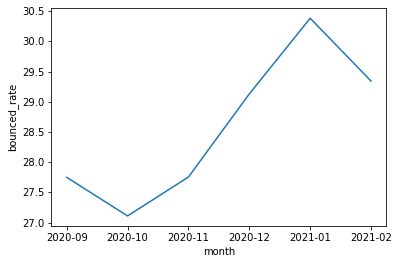

In [14]:
sns.lineplot(x=bounced['month'], y=bounced['bounced_rate'])

In [ ]:
# 이탈률이 증가하는 추세임.
# 유저들이 어떻게 유입됐는지 알 수 있으면 이탈 요인 분석할 수 있을 듯

In [ ]:
# 코호트별 이탈률 분석

In [65]:
cohort_month = pd.DataFrame(view_cnt_per_session.groupby(by='user_id')['month'].min()).reset_index()

In [66]:
cohort_month = cohort_month.rename(columns={'month':'cohort'})
view_cnt_per_session = pd.merge(view_cnt_per_session, cohort_month, on='user_id', how='left')

In [75]:
cohort_bounced = pd.DataFrame(view_cnt_per_session.groupby(by=['cohort', 'month'])['bounced'].mean()).reset_index()

In [76]:
cohort_bounced['bounced_rate'] = (1 - cohort_bounced['bounced']) * 100

In [77]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohort_bounced = cohort_bounced.groupby(by='cohort').apply(cohort_period)

In [79]:
cohort_bounced.set_index(['cohort', 'CohortPeriod'], inplace=True)

In [80]:
cohort_bounced_unstack = cohort_bounced[['bounced_rate']].unstack(level=0)

<AxesSubplot:title={'center':'월별 코호트 이탈율'}, xlabel='CohortPeriod', ylabel='None-cohort'>

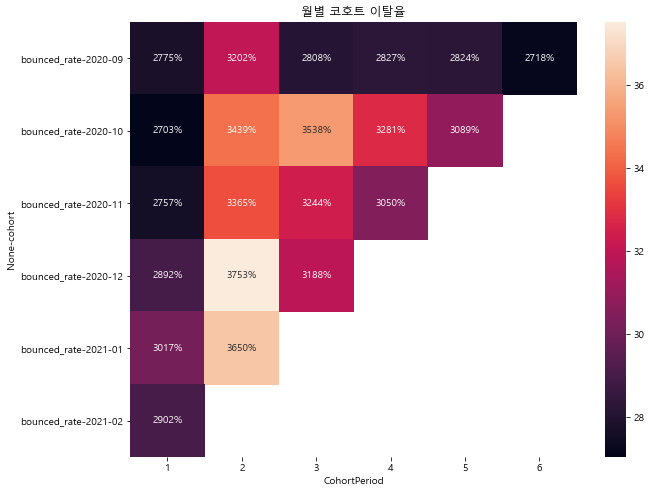

In [81]:
plt.figure(figsize=(10,8))
plt.title('월별 코호트 이탈율')
plt.rc('font', family='Malgun Gothic') #한글 폰트 설정
sns.heatmap(cohort_bounced_unstack.T, mask=cohort_bounced_unstack.T.isnull(), annot=True, fmt='.0%')

In [ ]:
# 시간이 지날수록 코호트별 month-1, month-2 .., month-5 이탈률이 증가하고 있어 첫 랜딩 경험이 악화되는 것으로 보임.
# 2020-09 코호트는 비교적 시간이 지나도 이탈율이 유지되나, 2020-10 코호트, 2020-11 코호트 등 이후 첫 접속한 코호트들은 시간이 지날수록 이탈률이 증가함.
# 재접속 시 원하는 것이 없다고 판단해 이탈하는 비율이 증가하는 것.

In [ ]:
# 고객 세그먼트별 이탈률 분석

In [ ]:
# RFM 이외에 브랜드 제품 구매 비율 변수를 추가해서 고객 분류

In [15]:
df_purchase = df[df['event_type']=='purchase'] #제품을 구매한 고객 데이터만 대상으로 함.
recent_date = pd.DataFrame(df_purchase.groupby(['user_id'])['datetime'].max().reset_index())

In [16]:
recent_date['datetime'].min()

Timestamp('2020-09-24 12:04:10+0000', tz='UTC')

In [17]:
recent_date['datetime'].max()

Timestamp('2021-02-28 23:30:24+0000', tz='UTC')

In [18]:
recent_date['recency'] = recent_date.datetime > '2020-12-01'

In [19]:
# Frequency: 고객별 주문건수 확인
# 주문 건별 아이디가 없어 같은 세션에서 구매했으면 같은 주문일 것으로 가정하고 세션을 카운트함.
freq = pd.DataFrame(df_purchase.groupby(['user_id'])['user_session'].count()).reset_index()
freq = freq.rename(columns={'user_session':'orders'})

In [20]:
# Monetary: 고객별 주문금액 집계
monetary = pd.DataFrame(df_purchase.groupby(['user_id'])['price'].sum()).reset_index()

In [21]:
rf = pd.merge(recent_date, freq, how='right', on='user_id')
rfm = pd.merge(rf, monetary, how='right', on='user_id')

In [22]:
# 브랜드 상품 구매 비율 계산
brand_purchase = pd.DataFrame(df_purchase.groupby(['user_id']).count()[['product_id', 'brand']]).reset_index()
brand_purchase['brand_pref'] = brand_purchase['brand'] / brand_purchase['product_id']

In [23]:
brand_purchase = brand_purchase[['user_id', 'brand_pref']]
rfmb = pd.merge(rfm, brand_purchase, how='right', on='user_id')

In [24]:
del rfmb['datetime']

In [25]:
from sklearn.cluster import KMeans
rfmb = pd.get_dummies(rfmb, columns=['recency'], drop_first = True)

In [26]:
rfmb.set_index('user_id', inplace=True)

<AxesSubplot:>

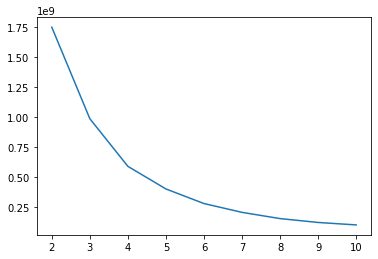

In [27]:
#적정그룹수 정하기
inertia = []

for i in range(2, 11):
    model = KMeans(n_clusters=i)
    model.fit(rfmb)
    inertia.append(model.inertia_)
    
sns.lineplot(x=list(range(2,11)), y=inertia)

In [28]:
# 4개를 클러스터 개수로 정하고 클러스터링 진행

model = KMeans(n_clusters=4)
model.fit(rfmb)
rfmb['cluster'] = model.labels_

In [29]:
pd.DataFrame(rfmb.groupby(by='cluster')['orders'].count()).rename(columns={'orders':'users'})

,users
cluster,
0,16574
1,812
2,3833
3,85


In [30]:
summary = rfmb.groupby('cluster').mean().reset_index()

<AxesSubplot:xlabel='cluster', ylabel='recency_True'>

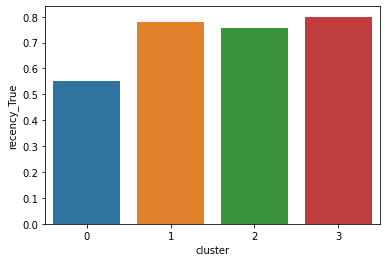

In [31]:
sns.barplot(x='cluster', y='recency_True', data=summary)

<AxesSubplot:xlabel='cluster', ylabel='orders'>

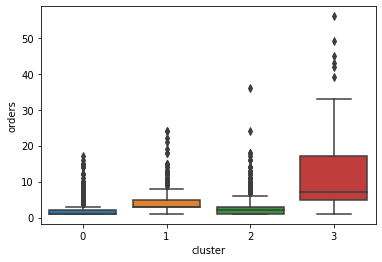

In [32]:
sns.boxplot(x='cluster', y='orders', data=rfmb)

<AxesSubplot:xlabel='cluster', ylabel='price'>

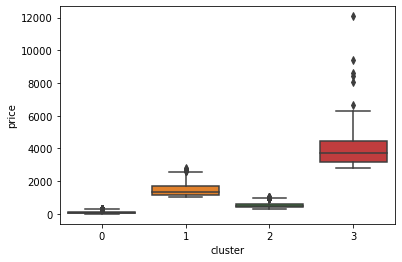

In [33]:
sns.boxplot(x='cluster', y='price', data=rfmb)

<AxesSubplot:xlabel='cluster', ylabel='brand_pref'>

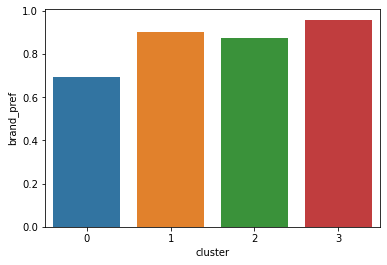

In [34]:
sns.barplot(x='cluster', y='brand_pref', data=summary)

In [37]:
rfmb_re = rfmb[['cluster']].reset_index()

In [48]:
view_cnt_per_session = pd.merge(view_cnt_per_session, rfmb_re, on='user_id', how='left')

In [46]:
#제품을 전혀 구매하지 않은 고객들은 기존 cluster에 해당하지 않으므로 4번 클러스터로 할당함.
view_cnt_per_session['cluster'] = view_cnt_per_session['cluster'].fillna(4)

In [55]:
bounced_cluster = pd.pivot_table(view_cnt_per_session, index=['cluster', 'month'], columns='bounced', aggfunc={'count'})['datetime']

In [56]:
bounced_cluster = bounced_cluster.reset_index(col_level=1)
bounced_cluster = bounced_cluster.droplevel(axis=1,level=0)
bounced_cluster = bounced_cluster.rename(columns={0:'bounced', 1:'not_bounced'})

In [58]:
bounced_cluster['bounced_rate'] = bounced_cluster['bounced'] / ( bounced_cluster['bounced'] + bounced_cluster['not_bounced'] ) * 100

In [59]:
bounced_cluster.head(5)

bounced,cluster,month,bounced,not_bounced,bounced_rate
0,0.0,2020-09,688,168,80.373832
1,0.0,2020-10,4028,1301,75.586414
2,0.0,2020-11,4723,1764,72.807153
3,0.0,2020-12,4000,1402,74.046649
4,0.0,2021-01,4180,1529,73.217726


In [62]:
bounced_cluster.set_index(['cluster', 'month'], inplace=True)

In [64]:
bounced_cluster_re = bounced_cluster['bounced_rate'].unstack(level=0)

<AxesSubplot:title={'center':'고객 세그먼트별 월별 이탈율'}, xlabel='month', ylabel='cluster'>

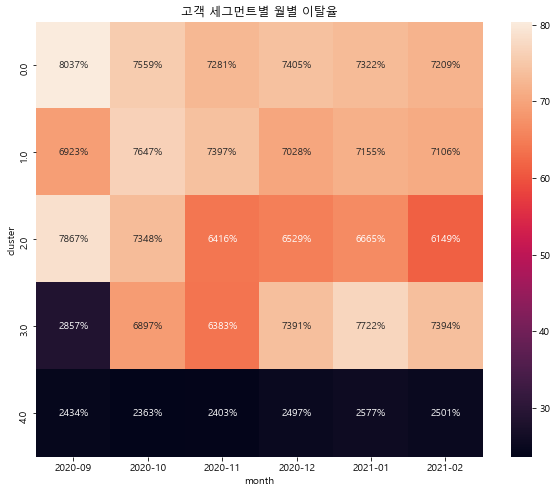

In [68]:
plt.figure(figsize=(10,8))
plt.rc('font', family='Malgun Gothic') #한글 폰트 설정
plt.title('고객 세그먼트별 월별 이탈율')
sns.heatmap(bounced_cluster_re.T, mask=bounced_cluster_re.T.isnull(), annot=True, fmt='.0%')

In [ ]:
# 가장 구매액이 높은 3번 그룹의 이탈율이 증가하고 있음. 2번째달부터 크게 증가.
# 구매액이 낮은 0번과 2번 그룹의 이탈율은 오히려 감소하는 추세임.
# 구매를 전혀하지 않은 4번 그룹은 이탈율이 굉장히 낮음. 즉 원하는 제품을 서칭하되 구매로는 이어지지 않는 것으로 보여 쿠폰 지급이나 할인을 통해 구매를 유도할 수 있을 것으로 보임. 또 장바구니 - 결제 퍼널이 보다 세분화되면 어느 단계에서 이탈하는지 추가분석할 수 있음.

In [70]:
df_re = pd.merge(df, rfmb_re, on='user_id', how='left')

In [74]:
df_re['cluster'] = df_re['cluster'].fillna(4)

In [80]:
df_re.groupby(['cluster', 'event_type']).count()

event_time  product_id  category_id  category_code  \
cluster event_type                                                       
0.0     cart             21418       21418        21418          16192   
        purchase         24472       24472        24472          18246   
        view             70886       70886        70886          54333   
1.0     cart              3080        3080         3080           2838   
        purchase          3567        3567         3567           3276   
        view             12163       12163        12163          11182   
2.0     cart              7332        7332         7332           6643   
        purchase          8289        8289         8289           7359   
        view             31543       31543        31543          28368   
3.0     cart               730         730          730            664   
        purchase          1018        1018         1018            897   
        view              2503        2503         2503           2296   
4.0     cart             21475       21475        21475          17289   
        view            676653      676653       676653         479327   

                     brand   price  user_id  user_session  datetime  
cluster event_type                                                   
0.0     cart         14938   21418    21418         21416     21418  
        purchase     16400   24472    24472         24472     24472  
        view         52040   70886    70886         70883     70886  
1.0     cart          2813    3080     3080          3080      3080  
        purchase      3212    3567     3567          3567      3567  
        view         10994   12163    12163         12163     12163  
2.0     cart          6459    7332     7332          7332      7332  
        purchase      7280    8289     8289          8289      8289  
        view         28106   31543    31543         31543     31543  
3.0     cart           687     730      730           730       730  
        purchase       953    1018     1018          1018      1018  
        view          2356    2503     2503          2503      2503  
4.0     cart         16614   21475    21475         21471     21475  
        view        509913  676653   676653        676497    676653

In [77]:
df_re.groupby('cluster').sum()

,product_id,category_id,price,user_id
cluster,,,,
0.0,2.162066e+11,2.504169e+23,9.507601e+06,1.770226e+23
1.0,5.465494e+10,4.033653e+22,6.351963e+06,2.851437e+22
2.0,1.255744e+11,1.011393e+23,1.347339e+07,7.149664e+22
3.0,1.281974e+10,9.115919e+21,1.587694e+06,6.444157e+21
4.0,1.278349e+12,1.497082e+24,9.859914e+07,1.058303e+24


In [79]:
df_re.groupby('user_id').count()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_session,datetime,cluster
user_id,,,,,,,,,,
1515915625353226922,1,1,1,1,1,1,1,1,1,1
1515915625353230067,1,1,1,1,0,1,1,1,1,1
1515915625353230683,13,13,13,13,13,13,13,13,13,13
1515915625353230922,1,1,1,1,1,1,1,1,1,1
1515915625353234047,36,36,36,36,35,36,36,36,36,36
...,...,...,...,...,...,...,...,...,...,...
1515915625611023671,1,1,1,1,1,0,1,1,1,1
1515915625611023730,1,1,1,1,0,0,1,1,1,1
1515915625611024014,1,1,1,1,1,1,1,1,1,1


In [ ]:
# 어떤 제품을 본 유저들이 이탈했는지 추가 분석 : 특정 제품군을 본 유저들이 많이 이탈했다면 해당 제품군은 이 사이트 이용자에게 별로 흥미를 주지 못하는 것으로 해석될 수 있음.

In [119]:
view_cnt_per_session = pd.merge(df[['user_session', 'datetime', 'category_code', 'brand']], view_cnt_per_session, on=['user_session', 'datetime'], how='right')

In [143]:
bounced_cat = pd.pivot_table(view_cnt_per_session, index=['month', 'category_code'], columns='bounced', aggfunc={'count'})['datetime'].fillna(0)

In [144]:
bounced_cat = bounced_cat.reset_index(col_level=1)
bounced_cat = bounced_cat.droplevel(axis=1,level=0)
bounced_cat = bounced_cat.rename(columns={0:'bounced', 1:'not_bounced'})

In [158]:
bounced_cat['bounced_rate'] = bounced_cat['bounced'] / ( bounced_cat['bounced'] + bounced_cat['not_bounced'] )

In [163]:
bounced_cat_tot = bounced_cat.groupby(by='category_code').sum()[['bounced', 'not_bounced']]

In [167]:
bounced_cat_tot['bounced_rate'] = bounced_cat_tot['bounced'] / ( bounced_cat_tot['bounced'] + bounced_cat_tot['not_bounced'] ) * 100

In [169]:
#이탈률이 높은 제품군 상위 50위
bounced_cat_tot.sort_values(by=['bounced_rate'], ascending=False)[:50]

bounced,bounced,not_bounced,bounced_rate
category_code,,,
furniture.bedroom.blanket,8.0,9.0,47.058824
computers.components.videocards,19525.0,23902.0,44.960508
auto.accessories.parktronic,371.0,515.0,41.873589
computers.peripherals.camera,988.0,1527.0,39.284294
electronics.audio.dictaphone,59.0,95.0,38.311688
computers.peripherals.scanner,387.0,652.0,37.247353
country_yard.cultivator,489.0,829.0,37.101669
computers.components.motherboard,4117.0,7026.0,36.946962
auto.accessories.player,3103.0,5562.0,35.810733


In [171]:
#이탈률이 낮은 제품군 상위 50위
bounced_cat_tot.sort_values(by=['bounced_rate'], ascending=True)[:50]

bounced,bounced,not_bounced,bounced_rate
category_code,,,
appliances.kitchen.washer,4.0,51.0,7.272727
auto.accessories.light,3.0,23.0,11.538462
country_yard.watering,4.0,30.0,11.764706
construction.tools.generator,18.0,126.0,12.500000
computers.gaming,23.0,145.0,13.690476
furniture.living_room.chair,5.0,31.0,13.888889
appliances.personal.scales,61.0,376.0,13.958810
kids.toys,19.0,107.0,15.079365
appliances.kitchen.refrigerators,2.0,11.0,15.384615
